In [42]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

n_detectors = 6
n_radii = 8
n_angles = 8
number_of_features = n_detectors*n_radii*n_angles
input_data = []
with open('data/PD033_time_norepeats_8radii_equidistant.dat', 'r') as inpf: 
    l = inpf.readline()
    print(l)
    for line in inpf:
        features = []
        s = line.strip().split()
        b = float(s[0])
        # for i in range(6):
            # for digit in s[i + 1]:
                # features.append(float(digit))
        for digit in s[1:]:
            features.append(float(digit))
        input_data.append([b, features])
    # print(len(input_data))
    
    np.random.shuffle(input_data)
    input_sorted = sorted(input_data, key=lambda x: (x[0]))
    # print(input_data)
    
    features = np.zeros((len(input_data), number_of_features))
    labels = np.zeros((len(input_data), 1))
    incr = 0
    for elem in input_data:
        labels[incr] = np.array(elem[0])
        features[incr] = np.array(elem[1])
        incr += 1
    
    # print(input_sorted[:5])
    # print(input_data[:5])
print(features.shape)

b 8 times 4 radii

(22000, 384)


In [43]:
# Encode labels into segments with equal length
def encode_equi_segment(b: float, maximum: float, groups: int) -> int:
    if b == maximum:
        return groups - 1
    else:
        length_of_segment = maximum / groups
        return int( b // length_of_segment )

    
# Encode labels into segments with equal size
def encode_equi_size(labels_arr: np.ndarray, groups: int ) -> np.ndarray:
    lb_sorted = np.sort(labels_arr, axis=0)
    segment = lb_sorted.shape[0]//groups
    print("Length of segment: {}".format(segment))
    borders = []
    
    # define borders of segments
    for i in range(groups):   
        if i != (groups - 1) and i != 0:
            borders.append((lb_sorted[(i)*segment].item(), lb_sorted[(i+1)*segment].item()))
        elif i == 0:
            borders.append((0, lb_sorted[(i+1)*segment].item()))
        else: 
            borders.append((lb_sorted[(i)*segment].item(), lb_sorted[labels.shape[0] - 1].item()))
    print("Encoded into intervals: {}" .format(borders))
    lb_enc = np.zeros_like(labels, dtype=np.int)
    incr = 0
    
    # iterate over all (not sorted) labels and encode them
    for elem in labels:   
        gr = 0
        for seg in borders:
            if seg[0] < elem <= seg[1]:
                lb_enc[incr] = gr
                break
            gr += 1
        incr += 1
    return lb_enc


number_of_groups = 4


# labels_encoded_list = []
# maximum_b = np.max(labels)
# for label in labels:
#     labels_encoded_list.append(encode_equi_segment(label[0], maximum_b, number_of_groups))
# labels_encoded = np.array(labels_encoded_list)
# train_labels = torch.flatten(torch.tensor(labels_encoded[:size_of_training_set]))
# test_labels = torch.flatten(torch.tensor(labels_encoded[size_of_training_set:]))


# Divide into test and training sets
size_of_training_set = int(features.shape[0] * 0.8)
size_of_test_set = features.shape[0] - size_of_training_set

train_features = torch.tensor(features[:size_of_training_set], dtype=torch.float32)
test_features = torch.tensor(features[size_of_training_set:], dtype=torch.float32)

print(labels[:10])
labels_encoded_equisized = encode_equi_size(labels, number_of_groups)
print(labels_encoded_equisized[:10])
train_labels = torch.flatten(torch.tensor(labels_encoded_equisized[:size_of_training_set]))
test_labels = torch.flatten(torch.tensor(labels_encoded_equisized[size_of_training_set:]))




print('Set shape: ' + str(features.shape))
print('Train features shape: ' + str(train_features.shape))
print('Train labels shape: ' + str(train_labels.shape))
print('Test features shape: ' + str(test_features.shape))
print('Test labels shape: ' + str(test_labels.shape))

[[15.294]
 [11.586]
 [12.508]
 [ 9.306]
 [ 2.199]
 [ 5.458]
 [10.821]
 [10.183]
 [11.541]
 [10.183]]
Length of segment: 5500
Encoded into intervals: [(0, 6.974), (6.974, 9.814), (9.814, 12.043), (12.043, 16.347)]
[[3]
 [2]
 [3]
 [1]
 [0]
 [0]
 [2]
 [2]
 [2]
 [2]]
Set shape: (22000, 384)
Train features shape: torch.Size([17600, 384])
Train labels shape: torch.Size([17600])
Test features shape: torch.Size([4400, 384])
Test labels shape: torch.Size([4400])


In [44]:
# Linear Fully connected network. 
# Convolutional - three blocks below

def get_correct_predictions(preds: torch.Tensor, values: torch.Tensor) -> int:
    return preds.argmax(dim=1).eq(values).sum().item()

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.lin1 = nn.Linear(in_features = number_of_features, out_features = 64)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        self.lin2 = nn.Linear(in_features = 64, out_features = 16)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)
        
        # self.lin3 = nn.Linear(in_features = 16, out_features = 30)
        # nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02)
        
        # self.lin4 = nn.Linear(in_features = 30, out_features = 20)
        # nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02)
        
        # self.lin5 = nn.Linear(in_features = 20, out_features = 12)
        # nn.init.normal_(self.lin5.weight, mean=0.0, std=0.02)
        
        # self.lin6 = nn.Linear(in_features = 12, out_features = 8)
        # nn.init.normal_(self.lin6.weight, mean=0.0, std=0.02)
        
        self.out = nn.Linear(in_features = 16, out_features = number_of_groups)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        # print(self.lin1.weight[:4, :8])
        # print(self.lin2.weight[:4, :8])
        # print(self.lin3.weight[:4, :8])
        # print(self.out.weight)
        
    def forward(self, t):
        t = t
        t = F.relu(self.lin1(t))
        t = F.relu(self.lin2(t))
        # t = F.relu(self.lin3(t))
        # t = F.relu(self.lin4(t))
        # t = F.relu(self.lin5(t))
        # t = F.relu(self.lin6(t))
        t = F.softmax(self.out(t), dim=1)
        return t

In [45]:
net = Network()
print(net.out.weight)
optimizer = optim.Adam(net.parameters(), lr=0.01)
number_of_epoches = 500
loss_weights = torch.tensor([1.,1.,1.,1.])


total_loss = []
total_accuracy = []
total_val_loss = []
total_val_accuracy = []

# Learning process
for epoch in range(number_of_epoches):
    predicted = net(train_features)
    loss = F.cross_entropy(predicted, train_labels, loss_weights)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    total_correct = get_correct_predictions(predicted, train_labels)
    print("Epoch: {:4d} |---> loss is {:4.10f}, total correct predictions: {:5d}, its {:.3f}%"
      .format(epoch, loss.item(), total_correct, total_correct*100/train_features.shape[0]))
    
    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss.append(loss.item())
        total_accuracy.append(total_correct*100/train_features.shape[0])
        
        test_preds = net(test_features)
        total_val_loss.append(F.cross_entropy(test_preds, test_labels, loss_weights).item())
        total_val_accuracy.append(get_correct_predictions(test_preds, test_labels)*100/test_features.shape[0])

Parameter containing:
tensor([[-0.0284,  0.0065, -0.0025,  0.0198,  0.0251, -0.0125, -0.0025, -0.0003,
         -0.0133, -0.0237, -0.0240, -0.0231,  0.0025,  0.0218,  0.0169, -0.0080],
        [ 0.0276,  0.0265,  0.0238, -0.0310, -0.0089, -0.0036,  0.0020, -0.0073,
          0.0071,  0.0102, -0.0115, -0.0141,  0.0354, -0.0143, -0.0236, -0.0216],
        [-0.0233,  0.0166,  0.0464, -0.0086, -0.0254,  0.0245, -0.0237,  0.0234,
         -0.0167, -0.0046, -0.0293, -0.0051, -0.0023,  0.0006,  0.0323, -0.0216],
        [-0.0558,  0.0041,  0.0056,  0.0219,  0.0010, -0.0105,  0.0165, -0.0079,
          0.0012,  0.0025,  0.0392,  0.0017, -0.0137,  0.0122, -0.0212, -0.0314]],
       requires_grad=True)
Epoch:    0 |---> loss is 1.3863229752, total correct predictions:  4362, its 24.784%
Epoch:    1 |---> loss is 1.3831715584, total correct predictions:  5679, its 32.267%
Epoch:    2 |---> loss is 1.3682519197, total correct predictions:  4443, its 25.244%
Epoch:    3 |---> loss is 1.3431073427, 

Epoch:   89 |---> loss is 0.9724601507, total correct predictions: 13755, its 78.153%
Epoch:   90 |---> loss is 0.9773349762, total correct predictions: 13670, its 77.670%
Epoch:   91 |---> loss is 0.9783627987, total correct predictions: 13643, its 77.517%
Epoch:   92 |---> loss is 0.9700539112, total correct predictions: 13772, its 78.250%
Epoch:   93 |---> loss is 0.9785763025, total correct predictions: 13668, its 77.659%
Epoch:   94 |---> loss is 0.9721490145, total correct predictions: 13763, its 78.199%
Epoch:   95 |---> loss is 0.9701007605, total correct predictions: 13794, its 78.375%
Epoch:   96 |---> loss is 0.9727788568, total correct predictions: 13751, its 78.131%
Epoch:   97 |---> loss is 0.9653392434, total correct predictions: 13861, its 78.756%
Epoch:   98 |---> loss is 0.9694759846, total correct predictions: 13789, its 78.347%
Epoch:   99 |---> loss is 0.9640378356, total correct predictions: 13874, its 78.830%
Epoch:  100 |---> loss is 0.9661514759, total correct 

Epoch:  187 |---> loss is 0.9319414496, total correct predictions: 14296, its 81.227%
Epoch:  188 |---> loss is 0.9318181872, total correct predictions: 14296, its 81.227%
Epoch:  189 |---> loss is 0.9316853285, total correct predictions: 14297, its 81.233%
Epoch:  190 |---> loss is 0.9315498471, total correct predictions: 14298, its 81.239%
Epoch:  191 |---> loss is 0.9314206839, total correct predictions: 14301, its 81.256%
Epoch:  192 |---> loss is 0.9312595725, total correct predictions: 14301, its 81.256%
Epoch:  193 |---> loss is 0.9310767651, total correct predictions: 14306, its 81.284%
Epoch:  194 |---> loss is 0.9309156537, total correct predictions: 14310, its 81.307%
Epoch:  195 |---> loss is 0.9308017492, total correct predictions: 14310, its 81.307%
Epoch:  196 |---> loss is 0.9306952357, total correct predictions: 14311, its 81.312%
Epoch:  197 |---> loss is 0.9305782318, total correct predictions: 14312, its 81.318%
Epoch:  198 |---> loss is 0.9304546714, total correct 

Epoch:  285 |---> loss is 0.9248479605, total correct predictions: 14384, its 81.727%
Epoch:  286 |---> loss is 0.9247975349, total correct predictions: 14384, its 81.727%
Epoch:  287 |---> loss is 0.9247654676, total correct predictions: 14385, its 81.733%
Epoch:  288 |---> loss is 0.9247457385, total correct predictions: 14385, its 81.733%
Epoch:  289 |---> loss is 0.9247438908, total correct predictions: 14385, its 81.733%
Epoch:  290 |---> loss is 0.9247734547, total correct predictions: 14385, its 81.733%
Epoch:  291 |---> loss is 0.9248172045, total correct predictions: 14386, its 81.739%
Epoch:  292 |---> loss is 0.9247297645, total correct predictions: 14387, its 81.744%
Epoch:  293 |---> loss is 0.9246082902, total correct predictions: 14388, its 81.750%
Epoch:  294 |---> loss is 0.9245193005, total correct predictions: 14388, its 81.750%
Epoch:  295 |---> loss is 0.9244589806, total correct predictions: 14389, its 81.756%
Epoch:  296 |---> loss is 0.9244211316, total correct 

Epoch:  382 |---> loss is 0.9225037694, total correct predictions: 14424, its 81.955%
Epoch:  383 |---> loss is 0.9220480919, total correct predictions: 14424, its 81.955%
Epoch:  384 |---> loss is 0.9220292568, total correct predictions: 14424, its 81.955%
Epoch:  385 |---> loss is 0.9223544002, total correct predictions: 14424, its 81.955%
Epoch:  386 |---> loss is 0.9221518636, total correct predictions: 14424, its 81.955%
Epoch:  387 |---> loss is 0.9220026731, total correct predictions: 14424, its 81.955%
Epoch:  388 |---> loss is 0.9219155312, total correct predictions: 14424, its 81.955%
Epoch:  389 |---> loss is 0.9218752384, total correct predictions: 14424, its 81.955%
Epoch:  390 |---> loss is 0.9218657017, total correct predictions: 14424, its 81.955%
Epoch:  391 |---> loss is 0.9218624830, total correct predictions: 14425, its 81.960%
Epoch:  392 |---> loss is 0.9219514132, total correct predictions: 14425, its 81.960%
Epoch:  393 |---> loss is 0.9222447276, total correct 

Epoch:  479 |---> loss is 0.9990352988, total correct predictions: 13098, its 74.420%
Epoch:  480 |---> loss is 0.9809293747, total correct predictions: 13410, its 76.193%
Epoch:  481 |---> loss is 0.9657779336, total correct predictions: 13682, its 77.739%
Epoch:  482 |---> loss is 0.9709806442, total correct predictions: 13590, its 77.216%
Epoch:  483 |---> loss is 0.9597069025, total correct predictions: 13786, its 78.330%
Epoch:  484 |---> loss is 0.9561021924, total correct predictions: 13841, its 78.642%
Epoch:  485 |---> loss is 0.9581471086, total correct predictions: 13813, its 78.483%
Epoch:  486 |---> loss is 0.9520794153, total correct predictions: 13943, its 79.222%
Epoch:  487 |---> loss is 0.9460858703, total correct predictions: 14043, its 79.790%
Epoch:  488 |---> loss is 0.9389531016, total correct predictions: 14183, its 80.585%
Epoch:  489 |---> loss is 0.9438185692, total correct predictions: 14084, its 80.023%
Epoch:  490 |---> loss is 0.9384632707, total correct 

Test accuracy is 59.16%


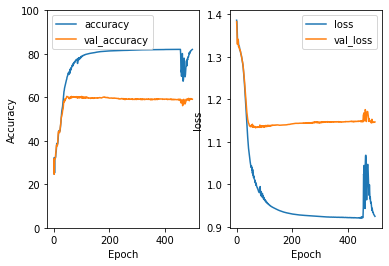

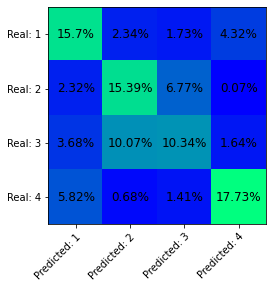

In [46]:
# Graphs and evaluation
with torch.no_grad():
    plt.subplot(1,2,1)
    plt.plot(total_accuracy, label='accuracy')
    plt.plot(total_val_accuracy, label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 100])
    plt.legend(loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(total_loss, label='loss')
    plt.plot(total_val_loss, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    
    
    test_predictions = net(test_features)
    test_correct_predictions = get_correct_predictions(test_predictions, test_labels)
    print("Test accuracy is {:2.2f}%" .format(test_correct_predictions * 100 /test_features.shape[0]))
    
    # Creating of confusion matrix
    stacked = torch.stack((test_labels, test_predictions.argmax(dim=1)), dim=1)
    # horizontal axis - predicted, vertical - true
    confusion_matrix = torch.zeros((number_of_groups,number_of_groups), dtype=torch.int32)      
    for row in stacked:
       confusion_matrix[row[0].item()][row[1].item()] += 1     # row is target, column - predicted
    # print(confusion_matrix)
    # print(400 - torch.count_nonzero(test_labels_tensor).item())
    
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix, cmap='winter')
    
    ax.set_xticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticks(np.arange(confusion_matrix.shape[1]))
    x_labels = []
    y_labels = []
    for i in range(confusion_matrix.shape[0]):
        x_labels.append('Predicted: '+ str(i + 1))
        y_labels.append('Real: ' + str(i + 1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            text = ax.text(j, i, str(round(confusion_matrix[i][j].item()*100/test_features.shape[0], 2)) + '%', ha="center", va="center", size=12)


[[15.294]
 [11.586]
 [12.508]]
[[3]
 [2]
 [3]]
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


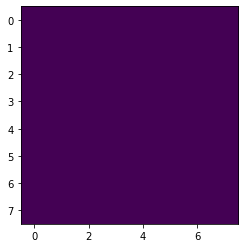

In [47]:
# Convolutional NN
features_reshaped = np.reshape(features, (features.shape[0], n_detectors, n_angles, n_radii))

train_features_c = torch.tensor(features_reshaped[:size_of_training_set], dtype=torch.float32)
test_features_c = torch.tensor(features_reshaped[size_of_training_set:], dtype=torch.float32)


print(labels[:3])
print(labels_encoded_equisized[:3])

# Equisized
train_labels_c = torch.flatten(torch.tensor(labels_encoded_equisized[:size_of_training_set]))
test_labels_c = torch.flatten(torch.tensor(labels_encoded_equisized[size_of_training_set:]))

# print(train_features_conv.shape)
print(train_features_c[0][0])
plt.imshow(train_features_c[0][0])
plt.show()
# print(train_features_c[0][1])
# plt.imshow(train_features_c[0][1])
# plt.show()

In [48]:
# Convolutional NN
class NetworkConv(nn.Module):
    def __init__(self):
        super(NetworkConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_detectors, out_channels=n_detectors*2, kernel_size=(4, 2))
        # self.conv1 = nn.Conv2d(in_channels=n_detectors, out_channels=n_detectors*2, kernel_size=(3, 3))
        nn.init.normal_(self.conv1.weight, mean=0.0, std=0.02)
        # print(self.conv1.weight)
        # self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=2)
        
        # self.lin1 = nn.Linear(in_features=n_detectors*2*5*3, out_features=60)
        self.lin1 = nn.Linear(in_features=n_detectors*2*5*7, out_features=60)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        self.lin2 = nn.Linear(in_features=60, out_features=16)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)

        # self.lin3 = nn.Linear(in_features=30, out_features=12)
        # nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02)
        
        # self.lin4 = nn.Linear(in_features=30, out_features=16)
        # nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02) 
        
        self.out = nn.Linear(in_features=16, out_features=number_of_groups)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        
    def forward(self, t):
        t = t
        t = F.relu(self.conv1(t))
        # t = F.relu(self.conv2(t))
        # t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = F.relu(self.lin1(t.reshape(-1, n_detectors*2*5*7)))
        t = F.relu(self.lin2(t))
        # t = F.relu(self.lin3(t))
        # t = F.relu(self.lin4(t))
        
        t = F.softmax(self.out(t), dim=1)
        return t

In [49]:
net_c = NetworkConv()
print(net_c.conv1.weight)
optimizer_c = optim.Adam(net_c.parameters(), lr=0.01, weight_decay=0.0001)
number_of_epoches_c = 500
# Here define weights for loss contribution of segments
loss_weights_c = torch.tensor([1.,1.,1.,1.])

total_loss_c = []
total_accuracy_c = []
total_val_loss_c = []
total_val_accuracy_c = []

# Learning process
for epoch in range(number_of_epoches_c):
    predicted_c = net_c(train_features_c)
    loss_c = F.cross_entropy(predicted_c, train_labels_c, loss_weights_c)
    optimizer_c.zero_grad()
    loss_c.backward()
    optimizer_c.step()
    
    total_correct_c = get_correct_predictions(predicted_c, train_labels_c)
    print("Epoch: {:4d} |---> loss is {:4.10f}, total correct predictions: {:5d}, its {:.3f}%"
      .format(epoch, loss_c.item(), total_correct_c, total_correct_c*100/train_features_c.shape[0]))
    
    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss_c.append(loss_c.item())
        total_accuracy_c.append(total_correct_c*100/train_features_c.shape[0])
        
        test_preds_c = net_c(test_features_c)
        total_val_loss_c.append(F.cross_entropy(test_preds_c, test_labels_c, loss_weights_c).item())
        total_val_accuracy_c.append(get_correct_predictions(test_preds_c, test_labels_c)*100/test_features_c.shape[0])

Parameter containing:
tensor([[[[ 0.0163,  0.0148],
          [-0.0001,  0.0349],
          [-0.0126, -0.0072],
          [-0.0356,  0.0045]],

         [[ 0.0299, -0.0070],
          [ 0.0152, -0.0137],
          [-0.0051,  0.0011],
          [ 0.0026, -0.0019]],

         [[-0.0017,  0.0051],
          [ 0.0178, -0.0065],
          [-0.0123, -0.0084],
          [-0.0158, -0.0187]],

         [[-0.0270, -0.0101],
          [ 0.0093,  0.0274],
          [ 0.0004,  0.0169],
          [-0.0066,  0.0121]],

         [[ 0.0128,  0.0160],
          [-0.0105,  0.0221],
          [ 0.0041,  0.0419],
          [-0.0033,  0.0147]],

         [[-0.0542, -0.0341],
          [ 0.0087,  0.0163],
          [-0.0036,  0.0149],
          [-0.0092,  0.0006]]],


        [[[ 0.0185,  0.0301],
          [ 0.0237,  0.0225],
          [ 0.0242,  0.0139],
          [-0.0331,  0.0129]],

         [[-0.0154,  0.0554],
          [-0.0318, -0.0094],
          [ 0.0053, -0.0108],
          [-0.0157, -0.0257]],



Epoch:    0 |---> loss is 1.3874046803, total correct predictions:  4370, its 24.830%
Epoch:    1 |---> loss is 1.3870083094, total correct predictions:  4370, its 24.830%
Epoch:    2 |---> loss is 1.3827983141, total correct predictions:  4370, its 24.830%
Epoch:    3 |---> loss is 1.3654382229, total correct predictions:  4391, its 24.949%
Epoch:    4 |---> loss is 1.3306127787, total correct predictions:  5165, its 29.347%
Epoch:    5 |---> loss is 1.3373343945, total correct predictions:  4578, its 26.011%
Epoch:    6 |---> loss is 1.3303210735, total correct predictions:  4663, its 26.494%
Epoch:    7 |---> loss is 1.3169960976, total correct predictions:  7164, its 40.705%
Epoch:    8 |---> loss is 1.3162353039, total correct predictions:  7984, its 45.364%
Epoch:    9 |---> loss is 1.3150024414, total correct predictions:  8660, its 49.205%
Epoch:   10 |---> loss is 1.3015381098, total correct predictions:  8424, its 47.864%
Epoch:   11 |---> loss is 1.2999536991, total correct 

Epoch:   97 |---> loss is 1.0824674368, total correct predictions: 11591, its 65.858%
Epoch:   98 |---> loss is 1.0818573236, total correct predictions: 11596, its 65.886%
Epoch:   99 |---> loss is 1.0800544024, total correct predictions: 11656, its 66.227%
Epoch:  100 |---> loss is 1.0787035227, total correct predictions: 11696, its 66.455%
Epoch:  101 |---> loss is 1.0782397985, total correct predictions: 11720, its 66.591%
Epoch:  102 |---> loss is 1.0771737099, total correct predictions: 11728, its 66.636%
Epoch:  103 |---> loss is 1.0764963627, total correct predictions: 11752, its 66.773%
Epoch:  104 |---> loss is 1.0760968924, total correct predictions: 11772, its 66.886%
Epoch:  105 |---> loss is 1.0751289129, total correct predictions: 11793, its 67.006%
Epoch:  106 |---> loss is 1.0744092464, total correct predictions: 11822, its 67.170%
Epoch:  107 |---> loss is 1.0741297007, total correct predictions: 11828, its 67.205%
Epoch:  108 |---> loss is 1.0746327639, total correct 

Epoch:  193 |---> loss is 1.0454518795, total correct predictions: 12344, its 70.136%
Epoch:  194 |---> loss is 1.0453662872, total correct predictions: 12335, its 70.085%
Epoch:  195 |---> loss is 1.0457941294, total correct predictions: 12335, its 70.085%
Epoch:  196 |---> loss is 1.0505398512, total correct predictions: 12223, its 69.449%
Epoch:  197 |---> loss is 1.0475929976, total correct predictions: 12269, its 69.710%
Epoch:  198 |---> loss is 1.0400625467, total correct predictions: 12449, its 70.733%
Epoch:  199 |---> loss is 1.0513956547, total correct predictions: 12187, its 69.244%
Epoch:  200 |---> loss is 1.0464189053, total correct predictions: 12324, its 70.023%
Epoch:  201 |---> loss is 1.0461874008, total correct predictions: 12303, its 69.903%
Epoch:  202 |---> loss is 1.0428760052, total correct predictions: 12366, its 70.261%
Epoch:  203 |---> loss is 1.0386688709, total correct predictions: 12471, its 70.858%
Epoch:  204 |---> loss is 1.0461387634, total correct 

Epoch:  289 |---> loss is 1.0814913511, total correct predictions: 11644, its 66.159%
Epoch:  290 |---> loss is 1.1120885611, total correct predictions: 11043, its 62.744%
Epoch:  291 |---> loss is 1.1091033220, total correct predictions: 11147, its 63.335%
Epoch:  292 |---> loss is 1.1050490141, total correct predictions: 11206, its 63.670%
Epoch:  293 |---> loss is 1.0975196362, total correct predictions: 11338, its 64.420%
Epoch:  294 |---> loss is 1.0776634216, total correct predictions: 11675, its 66.335%
Epoch:  295 |---> loss is 1.0451265574, total correct predictions: 12307, its 69.926%
Epoch:  296 |---> loss is 1.0884183645, total correct predictions: 11464, its 65.136%
Epoch:  297 |---> loss is 1.0939145088, total correct predictions: 11366, its 64.580%
Epoch:  298 |---> loss is 1.0503104925, total correct predictions: 12174, its 69.170%
Epoch:  299 |---> loss is 1.0475200415, total correct predictions: 12241, its 69.551%
Epoch:  300 |---> loss is 1.0704381466, total correct 

Epoch:  386 |---> loss is 0.9983530641, total correct predictions: 13171, its 74.835%
Epoch:  387 |---> loss is 1.0007119179, total correct predictions: 13144, its 74.682%
Epoch:  388 |---> loss is 0.9991465211, total correct predictions: 13168, its 74.818%
Epoch:  389 |---> loss is 0.9986441135, total correct predictions: 13175, its 74.858%
Epoch:  390 |---> loss is 0.9997013807, total correct predictions: 13160, its 74.773%
Epoch:  391 |---> loss is 0.9979364276, total correct predictions: 13182, its 74.898%
Epoch:  392 |---> loss is 0.9976766706, total correct predictions: 13194, its 74.966%
Epoch:  393 |---> loss is 0.9972169995, total correct predictions: 13202, its 75.011%
Epoch:  394 |---> loss is 0.9959838986, total correct predictions: 13216, its 75.091%
Epoch:  395 |---> loss is 0.9968955517, total correct predictions: 13210, its 75.057%
Epoch:  396 |---> loss is 0.9961053729, total correct predictions: 13224, its 75.136%
Epoch:  397 |---> loss is 0.9967851043, total correct 

Epoch:  483 |---> loss is 0.9842269421, total correct predictions: 13397, its 76.119%
Epoch:  484 |---> loss is 0.9840294123, total correct predictions: 13399, its 76.131%
Epoch:  485 |---> loss is 0.9838637710, total correct predictions: 13400, its 76.136%
Epoch:  486 |---> loss is 0.9837927222, total correct predictions: 13401, its 76.142%
Epoch:  487 |---> loss is 0.9837772846, total correct predictions: 13405, its 76.165%
Epoch:  488 |---> loss is 0.9836333394, total correct predictions: 13404, its 76.159%
Epoch:  489 |---> loss is 0.9834952950, total correct predictions: 13408, its 76.182%
Epoch:  490 |---> loss is 0.9833512902, total correct predictions: 13408, its 76.182%
Epoch:  491 |---> loss is 0.9833208919, total correct predictions: 13408, its 76.182%
Epoch:  492 |---> loss is 0.9832539558, total correct predictions: 13410, its 76.193%
Epoch:  493 |---> loss is 0.9832044840, total correct predictions: 13411, its 76.199%
Epoch:  494 |---> loss is 0.9830720425, total correct 

Test accuracy is 60.64%


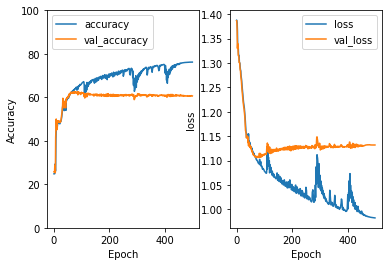

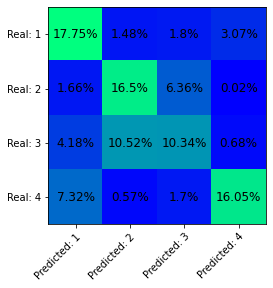

In [50]:
# Graphs and evaluation
with torch.no_grad():
    plt.subplot(1,2,1)
    plt.plot(total_accuracy_c, label='accuracy')
    plt.plot(total_val_accuracy_c, label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 100])
    plt.legend(loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(total_loss_c, label='loss')
    plt.plot(total_val_loss_c, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    
    
    test_predictions_c = net_c(test_features_c)
    test_correct_predictions_c = get_correct_predictions(test_predictions_c, test_labels_c)
    print("Test accuracy is {:2.2f}%" .format(test_correct_predictions_c * 100 /test_features_c.shape[0]))
    
    # Creating of confusion matrix
    stacked_c = torch.stack((test_labels_c, test_predictions_c.argmax(dim=1)), dim=1)
    confusion_matrix_c = torch.zeros((number_of_groups,number_of_groups), dtype=torch.int32)      
    # horizontal axis - predicted, vertical - true
    for row in stacked_c:
        confusion_matrix_c[row[0].item()][row[1].item()] += 1     # row is target, column - predicted
    
    # print(confusion_matrix)
    # print(400 - torch.count_nonzero(test_labels_tensor).item())
    
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix_c, cmap='winter')
    
    ax.set_xticks(np.arange(confusion_matrix_c.shape[0]))
    ax.set_yticks(np.arange(confusion_matrix_c.shape[1]))
    x_labels = []
    y_labels = []
    for i in range(confusion_matrix_c.shape[0]):
        x_labels.append('Predicted: '+ str(i + 1))
        y_labels.append('Real: ' + str(i + 1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(confusion_matrix_c.shape[0]):
        for j in range(confusion_matrix_c.shape[1]):
            text = ax.text(j, i, str(round(confusion_matrix_c[i][j].item()*100/test_features_c.shape[0],2)) + '%', ha="center", va="center", size=12)

In [52]:
# p1 = net_c.lin1.weight.clone().detach()
p1 = net.lin1.weight.clone().detach()
print(p1.shape)
u, s1, v = torch.svd(p1)
print(s1)
p2 = net_c.lin2.weight.clone().detach()
print(p2.shape)
u, s2, v = torch.svd(p2)
print(s2)

print(net_c.conv1.weight)
print(net_c.out.weight.shape)

torch.Size([64, 384])
tensor([14.2337, 12.2296,  9.7574,  9.2377,  8.5597,  8.2438,  7.5421,  7.4534,
         7.0556,  6.7096,  6.4875,  6.2839,  6.1072,  5.8893,  5.7214,  5.4046,
         5.2313,  4.7018,  3.9548,  3.6412,  3.3155,  2.5899,  2.5428,  2.3384,
         2.0638,  1.9265,  1.8057,  1.6191,  1.5641,  1.4563,  1.3649,  1.2898,
         1.2835,  1.1827,  1.0879,  0.9628,  0.8884,  0.8610,  0.8271,  0.7966,
         0.7394,  0.7210,  0.7143,  0.6389,  0.6141,  0.6102,  0.5710,  0.5235,
         0.4569,  0.4334,  0.4110,  0.3898,  0.3818,  0.3746,  0.3660,  0.3490,
         0.3425,  0.3318,  0.3187,  0.3027,  0.2965,  0.2925,  0.2803,  0.2610])
torch.Size([16, 60])
tensor([4.3182e+00, 3.6207e+00, 3.2013e+00, 1.4047e+00, 5.8879e-01, 3.5649e-01,
        2.5926e-01, 2.1863e-01, 1.7469e-01, 1.3808e-01, 9.4151e-02, 8.4252e-02,
        6.9303e-02, 1.7511e-02, 2.5389e-03, 2.2093e-04])
Parameter containing:
tensor([[[[ 3.1773e-01,  1.9855e-01],
          [ 2.3873e-01,  1.7159e-02],
 